In [1]:
from SimPEG import *
from simpegEM1D import EM1D, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, set_mesh_1d, piecewise_pulse
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [12]:
from simpegEM1D import skytem_HM_2015, skytem_LM_2015
wave_HM = skytem_HM_2015()
wave_LM = skytem_LM_2015()
time_HM = wave_HM.time_gate_center[0::2]
time_LM = wave_LM.time_gate_center[0::2]

hz = get_vertical_discretization_time(
    np.unique(np.r_[time_HM, time_LM]), facter_tmax=0.5, factor_tmin=10.
)
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC

time_input_currents_HM = wave_HM.current_times[-7:]
input_currents_HM = wave_HM.currents[-7:]
time_input_currents_LM = wave_LM.current_times[-13:]
input_currents_LM = wave_LM.currents[-13:]

TDsurvey = EM1DSurveyTD(
    rx_location = np.array([0., 0., 100.]),
    src_location = np.array([0., 0., 100.]),
    topo = np.r_[0., 0., 100.],
    depth = depth,
    rx_type = 'dBzdt',
    wave_type = 'general',
    src_type = 'CircularLoop',
    a = 13.,
    I = 1.,
    time = time_HM,
    time_input_currents=time_input_currents_HM,
    input_currents=input_currents_HM,
    n_pulse = 2,
    base_frequency = 25.,
    use_lowpass_filter=True,
    high_cut_frequency=210*1e3,
    moment_type='dual',
    time_dual_moment = time_HM,    
    time_input_currents_dual_moment=time_input_currents_LM,
    input_currents_dual_moment=input_currents_LM,
    base_frequency_dual_moment=210,    
)
sig_half = 1./20.
chi_half = 0.
expmap = Maps.ExpMap(mesh1D)

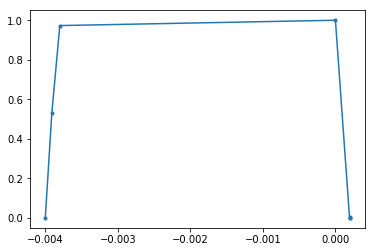

In [13]:
plt.plot(time_input_currents_HM, input_currents_HM, '.-')

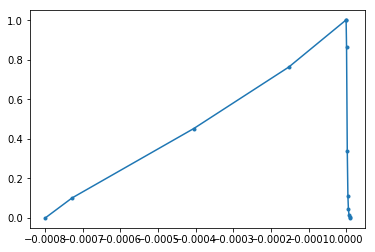

In [14]:
plt.plot(time_input_currents_LM, input_currents_LM, '.-')

In [15]:
sig  = np.ones(TDsurvey.n_layer)*sig_half
blk_ind = -10<LocSigZ
sig[blk_ind] = 1./20.
blk_ind = (-10>LocSigZ) & (-30<LocSigZ)
sig[blk_ind] = 1./100
blk_ind = (-100>LocSigZ) & (-150<LocSigZ)
sig[blk_ind] = 1./10.
m_true = np.log(sig)

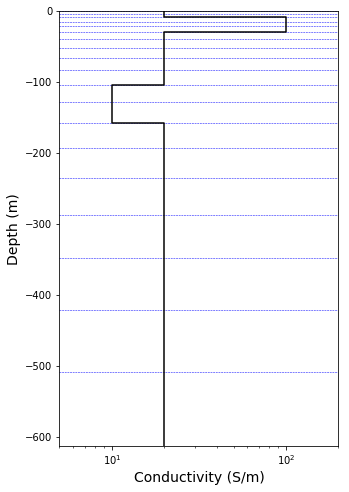

In [16]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(1./sig, mesh1D, showlayers=True)

In [17]:
e = np.empty(100, dtype=float)

In [18]:
e[2]

0.9513080761002755

In [19]:
TDsurvey.period_dual_moment

0.004761904761904762

In [20]:
TDsurvey.period

0.04

In [21]:
%%time
prob = EM1D(mesh1D, sigmaMap=expmap, verbose=False)
if prob.ispaired:
    prob.unpair()
if TDsurvey.ispaired:
    TDsurvey.unpair()
prob.pair(TDsurvey)
prob.chi = np.zeros(TDsurvey.n_layer)
d_true = TDsurvey.dpred(m_true)
# J = prob.getJ_sigma(m_true)

CPU times: user 37.2 ms, sys: 2.15 ms, total: 39.3 ms
Wall time: 37.2 ms


Text(0,0.5,'Voltage (V/A)')

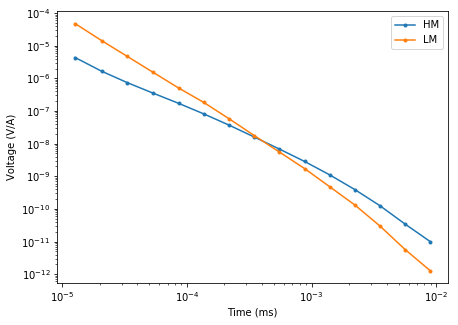

In [22]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -d_true[:TDsurvey.n_time], '.-')
axes.plot(TDsurvey.time_dual_moment, -d_true[TDsurvey.n_time:], '.-')
axes.set_xscale('log');
axes.set_yscale('log');
plt.legend(("HM", "LM"))
axes.set_xlabel("Time (ms)")
axes.set_ylabel("Voltage (V/A)")

In [13]:
np.random.seed(1)
TDsurvey.dtrue = d_true
std = 0.05
noise = std*abs(TDsurvey.dtrue)*np.random.randn(*TDsurvey.dtrue.shape)
floor = 0.
std = 0.07
TDsurvey.dobs = TDsurvey.dtrue+noise
uncert = abs(TDsurvey.dobs)*std+floor
dmisfit = DataMisfit.l2_DataMisfit(TDsurvey)
uncert = (abs(TDsurvey.dobs)*std+floor)
dmisfit.W = 1./ uncert
m0 = np.log(np.ones_like(sig)*sig_half)
d_0 = TDsurvey.dpred(m0)

In [17]:
reg = Regularization.Sparse(
    mesh1D,
    mapping=Maps.IdentityMap(mesh1D),
    alpha_s=1.,
    alpha_x=1.,
    cell_weights=mesh1D.vol,
)
p = 0
qx, qz = 2., 2.
reg.norms = np.c_[p, qx, qz, 0.]
IRLS = Directives.Update_IRLS(
    maxIRLSiter=20, minGNiter=1, fix_Jmatrix=False, coolingRate=2, betaSearch=False,
    chifact_start = 1.
)
opt = Optimization.ProjectedGNCG(maxIter = 25)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2., coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
target = Directives.TargetMisfit()
# update_sense = Directives.UpdateSensitivityWeights(threshold=delta)
inv = Inversion.BaseInversion(invProb, directiveList=[IRLS, betaest])
# inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target])
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')

/Users/sgkang/Projects/simpeg/SimPEG/Directives.py:886: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


In [18]:
%%time
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.40e+00  6.35e+02  0.00e+00  6.35e+02    1.17e+03      0              
   1  4.40e+00  6.40e+01  6.31e+00  9.17e+01    1.55e+02      0              
   2  2.20e+00  3.03e+01  9.05e+00  5.02e+01    3.85e+01      0   Skip BFGS  
   3  2.20e+00  1.88e+01  1.27e+01  4.66e+01    2.86e+00      0   Skip BFGS  
   4  1.10e+00  1.86e+01  1.27e+01  3.26e+01    2.53e+01      0   Skip BFGS  
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.7044740934641749 eps_q: 0.7044740934641749
Eps_p: 0.587061744

In [19]:
opt.counter.summary()
xc = opt.recall('xc')

Counters:
  ProjectedGNCG.activeSet                 :       20
  ProjectedGNCG.doEndIteration            :       20
  ProjectedGNCG.doStartIteration          :       20
  ProjectedGNCG.projection                :       83
  ProjectedGNCG.scaleSearchDirection      :       20

Times:                                        mean      sum
  EM1D.Jtvec_approx                       : 6.09e-04, 7.37e-02,  121x
  EM1D.Jvec_approx                        : 1.86e-03, 2.25e-01,  121x
  ProjectedGNCG.findSearchDirection       : 4.78e-02, 9.57e-01,   20x
  ProjectedGNCG.minimize                  : 6.53e+00, 6.53e+00,    1x
  ProjectedGNCG.modifySearchDirection     : 7.76e-02, 1.55e+00,   20x


(-300, 0)

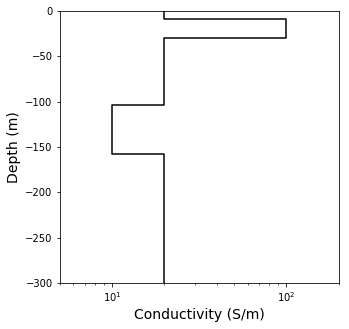

In [40]:
fig, axs = subplots(1,1, figsize=(5, 5))
Utils1D.plotLayer(1./sig, mesh1D, ax=axs)
axs.set_ylim(-300, 0)

Text(0.5,1,'Sparse')

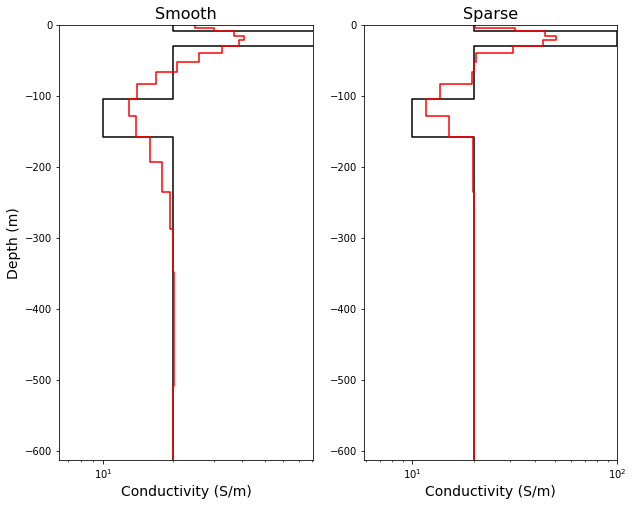

In [20]:
fig, axs = subplots(1,2, figsize=(10, 8))
Utils1D.plotLayer(1./sig, mesh1D, ax=axs[0])
Utils1D.plotLayer(1./sig, mesh1D, ax=axs[1])
Utils1D.plotLayer(1./(expmap*invProb.l2model), mesh1D, showlayers=False, **{'color':'r'}, ax=axs[0])
Utils1D.plotLayer(1./(expmap*mopt), mesh1D, showlayers=False, **{'color':'r'}, ax=axs[1])
axs[1].set_ylabel("")
axs[0].set_title("Smooth", fontsize = 16)
axs[1].set_title("Sparse", fontsize = 16)

Text(0,0.5,'Voltage (V/A)')

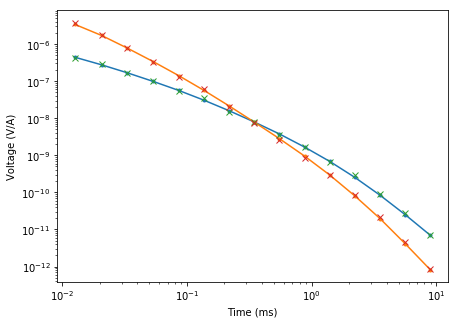

In [22]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time*1e3, -invProb.dpred[:TDsurvey.n_time], '.-')
axes.plot(TDsurvey.time_dual_moment*1e3, -invProb.dpred[TDsurvey.n_time:], '.-')
axes.plot(TDsurvey.time*1e3, -TDsurvey.dobs[:TDsurvey.n_time], 'x')
axes.plot(TDsurvey.time_dual_moment*1e3, -TDsurvey.dobs[TDsurvey.n_time:], 'x')
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel("Time (ms)")
axes.set_ylabel("Voltage (V/A)")